In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Input
from keras.layers import Conv2D,MaxPooling2D
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
IMG_HEIGHT= 48
IMG_WIDTH = 48
batch_size= 32

In [3]:
train_data_dir='../input/fer2013/train/'
validation_data_dir='../input/fer2013/test/'

In [4]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					#color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							#color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

In [8]:
img, label = train_generator.__next__()

In [9]:
img.shape

(32, 48, 48, 3)

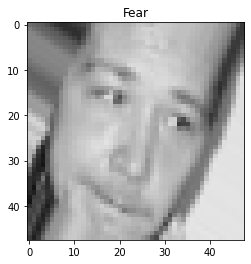

In [10]:
import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image, cmap='gray')
plt.title(labl)
plt.show()

In [11]:
#import cv2
#color_image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#plt.imshow(color_image)
#plt.show()

In [12]:
conv_base = VGG16(include_top = False,input_shape=(48,48,3))

2022-06-21 07:05:41.324778: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 0s 0us/step


In [13]:
#
for layers in conv_base.layers:
    layers.trainable = False

In [14]:
from keras.models import Model
from tensorflow.keras.layers import Input

#top_model = conv_base.output
#top_model = Flatten(name="flatten")(top_model)
#output_layer = Dense(7, activation='softmax')(top_model)

x = Flatten()(conv_base.output)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(14, activation = "relu")(x)
output_layer = Dense(7, activation = "softmax")(x)

    
# Group the convolutional base and new fully-connected layers into a Model object.
model = Model(inputs=conv_base.input, outputs=output_layer)

In [15]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [16]:
train_path = "../input/fer2013/train/"
test_path = "../input/fer2013/test"

In [17]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

In [18]:
epochs=20

In [19]:
history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//batch_size)

2022-06-21 07:05:48.130700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
897/897 [==============================] - 447s 497ms/step - loss: 1.7566 - accuracy: 0.2836 - val_loss: 1.6646 - val_accuracy: 0.3299
Epoch 2/20
897/897 [==============================] - 444s 495ms/step - loss: 1.6939 - accuracy: 0.3192 - val_loss: 1.6383 - val_accuracy: 0.3545
Epoch 3/20
897/897 [==============================] - 450s 501ms/step - loss: 1.6708 - accuracy: 0.3385 - val_loss: 1.6053 - val_accuracy: 0.3736
Epoch 4/20
897/897 [==============================] - 458s 511ms/step - loss: 1.6603 - accuracy: 0.3417 - val_loss: 1.6271 - val_accuracy: 0.3643
Epoch 5/20
897/897 [==============================] - 460s 513ms/step - loss: 1.6494 - accuracy: 0.3473 - val_loss: 1.6007 - val_accuracy: 0.3770
Epoch 6/20
897/897 [==============================] - 464s 517ms/step - loss: 1.6435 - accuracy: 0.3524 - val_loss: 1.5885 - val_accuracy: 0.3750
Epoch 7/20
897/897 [==============================] - 463s 516ms/step - loss: 1.6358 - accuracy: 0.3539 - val_loss: 1.5783 -

In [20]:
model.save('emotion_detection_model.h5')

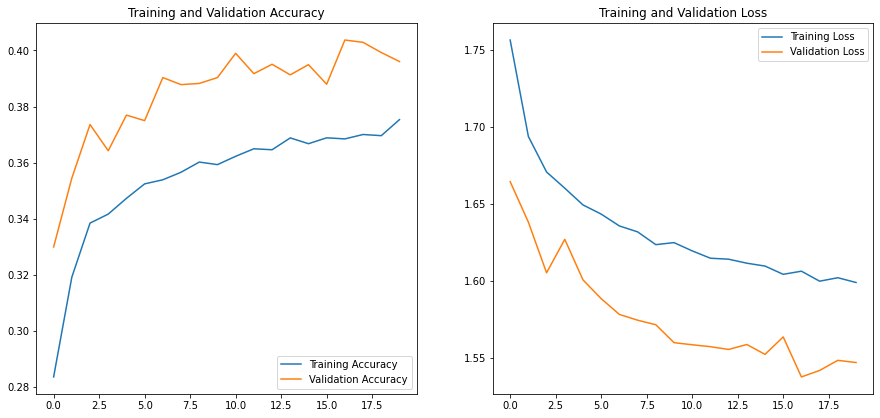

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
